[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainerRL_quickstart.ipynb)

# ChainerRL Quickstart Guide

This is a quickstart guide for users who just want to try ChainerRL for the first time.

Run the command below to install ChainerRL:


In [0]:
# Install Chainer, ChainerRL and CuPy!

!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip -q install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip -q install 'chainer==4.0.0b3'
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

First, you need to import necessary modules. The module name of ChainerRL is `chainerrl`. Let's import `gym` and `numpy` as well since they are used later.

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

ChainerRL can be used for any problems if they are modeled as "environments". [OpenAI Gym](https://github.com/openai/gym) provides various kinds of benchmark environments and defines the common interface among them. ChainerRL uses a subset of the interface. Specifically, an environment must define its observation space and action space and have at least two methods: `reset` and `step`.

- `env.reset` will reset the environment to the initial state and return the initial observation.
- `env.step` will execute a given action, move to the next state and return four values:
  - a next observation
  - a scalar reward
  - a boolean value indicating whether the current state is terminal or not
  - additional information
- `env.render` will render the current state.

Let's try 'CartPole-v0', which is a classic control problem. You can see below that its observation space consists of four real numbers while its action space consists of two discrete actions.

In [13]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
#env.render()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(4,)
action space: Discrete(2)
initial observation: [-0.02484356  0.04598068  0.02055234 -0.00409672]
next observation: [-0.02392395 -0.1494299   0.0204704   0.29499921]
reward: 1.0
done: False
info: {}


Now you have defined your environment. Next, you need to define an agent, which will learn through interactions with the environment.

ChainerRL provides various agents, each of which implements a deep reinforcement learning algorithm.

To use [DQN (Deep Q-Network)](http://dx.doi.org/10.1038/nature14236), you need to define a Q-function that receives an observation and returns an expected future return for each action the agent can take. In ChainerRL, you can define your Q-function as `chainer.Link` as below. Note that the outputs are wrapped by `chainerrl.action_value.DiscreteActionValue`, which implements `chainerrl.action_value.ActionValue`. By wrapping the outputs of Q-functions, ChainerRL can treat discrete-action Q-functions like this and [NAFs (Normalized Advantage Functions)](https://arxiv.org/abs/1603.00748) in the same way.

In [0]:
class QFunction(chainer.Chain):

    def __init__(self, obs_size, n_actions, n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l2 = L.Linear(n_hidden_channels, n_actions)

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
        """
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

If you want to use CUDA for computation, as usual as in Chainer, call `to_gpu`.

**When using Colaboratory, you need to change runtime type to GPU**.


In [15]:
q_func.to_gpu(0)

You can also use ChainerRL's predefined Q-functions.

In [0]:
_q_func = chainerrl.q_functions.FCStateQFunctionWithDiscreteAction(
    obs_size, n_actions,
    n_hidden_layers=2, n_hidden_channels=50)

As in Chainer, `chainer.Optimizer` is used to update models.

In [0]:
# Use Adam to optimize q_func. eps=1e-2 is for stability.
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

A Q-function and its optimizer are used by a DQN agent. To create a DQN agent, you need to specify a bit more parameters and configurations.

In [0]:
# Set the discount factor that discounts future rewards.
gamma = 0.95

# Use epsilon-greedy for exploration
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

# Since observations from CartPole-v0 is numpy.float64 while
# Chainer only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(np.float32, copy=False)

# Now create an agent that will interact with the environment.
agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

Now you have an agent and an environment. It's time to start reinforcement learning!

In training, use `agent.act_and_train` to select exploratory actions. `agent.stop_episode_and_train` must be called after finishing an episode. You can get training statistics of the agent via `agent.get_statistics`.

In [19]:
n_episodes = 1000
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

episode: 10 R: 14.0 statistics: [('average_q', -0.0073503046765069574), ('average_loss', 0)]
episode: 20 R: 13.0 statistics: [('average_q', 0.00378637458505154), ('average_loss', 0)]
episode: 30 R: 12.0 statistics: [('average_q', -0.009655200299510669), ('average_loss', 0)]
episode: 40 R: 11.0 statistics: [('average_q', -0.015202838162879574), ('average_loss', 0)]
episode: 50 R: 8.0 statistics: [('average_q', 0.011154073613225974), ('average_loss', 0.1603191076390122)]
episode: 60 R: 14.0 statistics: [('average_q', 0.1296764836051749), ('average_loss', 0.12565334444702084)]
episode: 70 R: 10.0 statistics: [('average_q', 0.3343780097916005), ('average_loss', 0.11446633328701175)]
episode: 80 R: 13.0 statistics: [('average_q', 0.6790537738010559), ('average_loss', 0.14953278866697492)]
episode: 90 R: 15.0 statistics: [('average_q', 1.0999339203700325), ('average_loss', 0.18850011210364737)]
episode: 100 R: 24.0 statistics: [('average_q', 1.7133163835792664), ('average_loss', 0.2664883438

Now you finished training the agent. How good is the agent now? You can test it by using `agent.act` and `agent.stop_episode` instead. Exploration such as epsilon-greedy is not used anymore.

In [0]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)


test episode: 0 R: 161.0
test episode: 1 R: 177.0
test episode: 2 R: 174.0


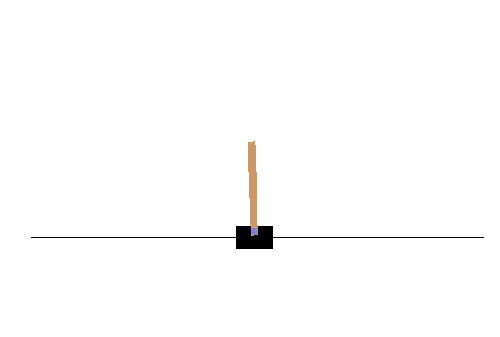

In [11]:
frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

Recording video file.

In [20]:

# wrap env for recording video
envw = gym.wrappers.Monitor(env, "./", force=True)

for i in range(3):
    obs = envw.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        envw.render()
        action = agent.act(obs)
        obs, r, done, _ = envw.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()

test episode: 0 R: 200.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0


Download videos on runnning.

In [0]:
from google.colab import files
import glob

for file in glob.glob("openaigym.video.*.mp4"):
  files.download(file)

You should remove video files.

In [0]:
!rm openaigym.video.*

If test scores are good enough, the only remaining task is to save the agent so that you can reuse it. What you need to do is to simply call `agent.save` to save the agent, then `agent.load` to load the saved agent.

In [0]:
# Save an agent to the 'agent' directory
agent.save('agent')

# Uncomment to load an agent from the 'agent' directory
# agent.load('agent')

RL completed!

But writing code like this every time you use RL might be boring. So, ChainerRL has utility functions that do these things.

In [0]:
# Set up the logger to print info messages for understandability.
import logging
import sys
gym.undo_logger_setup()  # Turn off gym's default logger settings
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

chainerrl.experiments.train_agent_with_evaluation(
    agent, env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_runs=10,       # 10 episodes are sampled for each evaluation
    max_episode_len=200,  # Maximum length of each episodes
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result')      # Save everything to 'result' directory

/usr/local/lib/python3.6/dist-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")


outdir:result step:200 episode:0 R:200.0
statistics:[('average_q', 20.13107348407955), ('average_loss', 0.1130567486698384)]
outdir:result step:320 episode:1 R:120.0
statistics:[('average_q', 20.134093816794454), ('average_loss', 0.13519476892439852)]
outdir:result step:520 episode:2 R:200.0
statistics:[('average_q', 20.09233843875654), ('average_loss', 0.1332404190763901)]
outdir:result step:720 episode:3 R:200.0
statistics:[('average_q', 20.081831597545516), ('average_loss', 0.13068583669631)]
outdir:result step:901 episode:4 R:181.0
statistics:[('average_q', 19.99495162254429), ('average_loss', 0.09401080450214364)]
outdir:result step:1101 episode:5 R:200.0
statistics:[('average_q', 20.014892631038933), ('average_loss', 0.11939343070713773)]
test episode: 0 R: 200.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0
test episode: 3 R: 200.0
test episode: 4 R: 200.0
test episode: 5 R: 200.0
test episode: 6 R: 200.0
test episode: 7 R: 200.0
test episode: 8 R: 200.0
test episode: 9 R: 2

That's all of the ChainerRL quickstart guide. To know more about ChainerRL, please look into the `examples` directory and read and run the examples. Thank you!